# 2.156 Final Project
**Becca Sholler, Grayson Adams, Ryan DeQuintal**

## Load Data

In [370]:
import os
import shutil
import random
from pathlib import Path
import requests
from urllib.parse import urlencode, urlparse, parse_qsl, urlunparse
from tqdm import tqdm

data_dir = "https://www.dropbox.com/scl/fo/3d3kttc96e8a5izrhr9du/ABGbVWFKYaUZNu9jtNVnwDY?rlkey=lvo18dm41lb4jbyarzznvwtvx&st=gv5sxb2t&dl=0"
source_root = Path("data/source_dataset")
target_root = Path("data/split_dataset")
splits = ["train", "val", "test"]
ratios = {"train": 0.7, "val": 0.15, "test": 0.15}

def _to_direct_dropbox(url):
    parsed = urlparse(url)
    query = dict(parse_qsl(parsed.query))
    query["dl"] = "1"
    return urlunparse(parsed._replace(query=urlencode(query)))

needToDownload = False
if needToDownload:
    download_url = _to_direct_dropbox(data_dir)
    zip_path = source_root.parent / "source_dataset.zip"
    source_root.mkdir(parents=True, exist_ok=True)

    print(f"Downloading dataset from Dropbox...")
    with requests.get(download_url, stream=True) as resp:
        resp.raise_for_status()
        total_size = int(resp.headers.get('content-length', 0))
        
        with open(zip_path, "wb") as fh:
            with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
                for chunk in resp.iter_content(chunk_size=8192):
                    if chunk:
                        fh.write(chunk)
                        pbar.update(len(chunk))

    print("Extracting archive...")
    shutil.unpack_archive(str(zip_path), str(source_root))
    zip_path.unlink()
    print('✓ Files downloaded and extracted.')

    print("Creating train/val/test splits...")
    # Create target folders
    for split in splits:
        for class_name in os.listdir(source_root):
            class_path = os.path.join(source_root, class_name)
            if os.path.isdir(class_path):
                os.makedirs(os.path.join(target_root, split, class_name), exist_ok=True)

    # Split the data per class
    random.seed(2156)
    for class_name in tqdm(os.listdir(source_root), desc="Splitting classes"):
        class_dir = os.path.join(source_root, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        random.shuffle(images)

        n = len(images)
        n_train = int(n * ratios["train"])
        n_val   = int(n * ratios["val"])

        train_files = images[:n_train]
        val_files   = images[n_train:n_train+n_val]
        test_files  = images[n_train+n_val:]

        for f in train_files:
            shutil.copy(os.path.join(class_dir, f), 
                        os.path.join(target_root, "train", class_name, f))
        for f in val_files:
            shutil.copy(os.path.join(class_dir, f), 
                        os.path.join(target_root, "val", class_name, f))
        for f in test_files:
            shutil.copy(os.path.join(class_dir, f), 
                        os.path.join(target_root, "test", class_name, f))

    print("✓ Dataset split completed.")

    print("\n" + "="*50)
    print("DATASET READY")
    print(f"Source: {source_root}")
    print(f"Split dataset: {target_root}")
    print("="*50)
else:
    print("Dataset already downloaded and split.")

Dataset already downloaded and split.


## Model Class Wrappers

In [371]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm, trange
import seaborn as sns
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [372]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

### Resnet

In [373]:
import torchvision.models as models

## RESNET18 with Spatial Masking
class SpatialMask(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, 1, kernel_size=1)
    
    def forward(self, x):
        mask = torch.sigmoid(self.conv(x))   # output in [0,1]
        return x * mask

class ResNetWithMask(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.is_multiview_model = False
        self.backbone = models.resnet18(weights='DEFAULT')
        
        # Insert masking after layer4 outputs 512 channels
        self.mask = SpatialMask(512)
        
        # Replace classifier head
        self.backbone.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Run through all layers except fc
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # Apply learned mask here
        x = self.mask(x)

        # Continue through classifier
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.fc(x)

        return x

### CLIP

In [374]:
class MultiViewAggregator(nn.Module):
    def __init__(self, embed_dim, policy='attention'):
        super().__init__()
        self.policy = policy
        
        if policy == 'attention':
            # A small network to calculate the "importance" score of each view
            self.attention_head = nn.Sequential(
                nn.Linear(embed_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 1)
            )

    def forward(self, x):
        # x shape: [Batch, Views, Features]
        
        if self.policy == 'mean':
            return x.mean(dim=1)
        
        elif self.policy == 'max':
            # Max pooling captures the strongest feature activation across views
            return x.max(dim=1).values
        
        elif self.policy == 'attention':
            # Calculate attention scores for each view
            # scores: [Batch, Views, 1]
            attn_scores = self.attention_head(x) 
            attn_weights = F.softmax(attn_scores, dim=1)
            
            # Weighted sum of views
            # [B, V, 1] * [B, V, D] -> [B, V, D] -> sum(dim=1) -> [B, D]
            weighted_features = (x * attn_weights).sum(dim=1)
            return weighted_features
            
        else:
            raise ValueError(f"Unknown policy: {self.policy}")

class CLIPMultiViewClassifier(nn.Module):
    def __init__(self, clip_model, embed_dim, num_classes, freeze_backbone=True, aggregation='attention'):
        super().__init__()
        self.is_multiview_model = True
        self.clip = clip_model

        if freeze_backbone:
            for p in self.clip.parameters():
                p.requires_grad = False

        # Add the aggregation layer
        self.aggregator = MultiViewAggregator(embed_dim, policy=aggregation)

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.BatchNorm1d(512), # Added BatchNorm for stability
            nn.ReLU(),
            nn.Dropout(0.3),     # Added Dropout to prevent overfitting
            nn.Linear(512, num_classes)
        )

    def forward(self, views):
        # views: [B, V, C, H, W]
        B, V, C, H, W = views.shape

        # Flatten views into batch dimension for CLIP encoding
        views = views.view(B * V, C, H, W)

        # Encode with CLIP
        features = self.clip.encode_image(views)  # [B*V, D]
        
        # Normalize features (critical for CLIP!)
        features = features / features.norm(dim=-1, keepdim=True)

        # Reshape back to [B, V, D]
        features = features.view(B, V, -1)

        # Aggregate Views (Learn which view is best)
        aggregated_features = self.aggregator(features)  # [B, D]

        # Classify
        logits = self.classifier(aggregated_features)
        return logits


### DinoV2

In [375]:
class DinoClassifier(nn.Module):
    def __init__(self, num_classes, freeze_backbone=True):
        super().__init__()
        self.is_multiview_model = False # Single view standard model
        
        # Load backbone from torch hub
        self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=True)
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # ViT-S/14 output dim is 384
        self.embed_dim = 384 
        
        self.head = nn.Sequential(
            nn.Linear(self.embed_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # x: [B, C, H, W]
        
        # DinoV2 forward_features returns a dict
        # We want 'x_norm_clstoken' (the CLS token)
        features = self.backbone.forward_features(x)
        cls_token = features['x_norm_clstoken']
        
        logits = self.head(cls_token)
        return logits

In [376]:
class MultiViewImageDataset(Dataset):
    def __init__(self, root, base_transform, num_views=4):
        # Use ImageFolder to get file paths + labels, but handle transforms ourselves
        self.folder = datasets.ImageFolder(root, transform=None)
        self.transform = base_transform
        self.num_views = num_views
        self.classes = self.folder.classes
        self.samples = self.folder.samples
        self.loader = self.folder.loader

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = self.loader(path)

        # Generate V different augmented views of the same image
        views = [self.transform(img) for _ in range(self.num_views)]
        views = torch.stack(views, dim=0)  # [V, C, H, W]

        return views, label


## SELECT MODEL HERE

In [377]:
model_name = 'dinov2'

if (model_name == 'ResNetWithMask' or 
    model_name == 'ResNet18' or
    model_name == 'dinov2'):
    size = (336, 336)

    normalize = transforms.Normalize(
        mean=imagenet_mean,
        std=imagenet_std,
    )
    
    train_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
        normalize
        ])

    eval_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        normalize
    ])
elif model_name == 'CLIP':
    !pip install --quiet open_clip_torch
    import open_clip
    clip_model, train_transform, eval_transform = open_clip.create_model_and_transforms(
        'ViT-B-32', pretrained='laion2b_s34b_b79k'
    )

## Load Images

In [378]:
num_views = 2
# train_data = datasets.ImageFolder(target_root / "train", transform=train_transform)
# val_data = datasets.ImageFolder(target_root / "val", transform=eval_transform)
# test_data = datasets.ImageFolder(target_root / "test", transform=eval_transform)
train_data = MultiViewImageDataset(target_root / "train", train_transform,  num_views=num_views)
val_data   = MultiViewImageDataset(target_root / "val",   eval_transform,   num_views=num_views)
test_data  = MultiViewImageDataset(target_root / "test",  eval_transform,   num_views=num_views)

batch_size = 16  # smaller batch because V views per image
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(train_data.classes)

print(train_data.classes)
print(len(train_data))
views, labels = next(iter(train_loader))
print("views shape:", views.shape)  # should be [B, V, C, H, W]

train_labels = [label for _, label in train_data.samples]
class_counts = np.bincount(train_labels)
print("Class counts:", class_counts)

class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.mean()
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

views = views.to(device)

['Victaulic_AWWA_Cap_No 60-C (DRG)_10 (250)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_12 (300)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_14 (350)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_16 (400)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_18 (450)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_20 (500)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_24 (600)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_30 (750)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_36 (900)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_4 (100)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_6 (150)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_8 (200)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_1.5 (40)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_10 (250)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_12 (300)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_2 (50)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_3 (80)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_4 (100)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_6 (150)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_8 (200)', 'Victaulic_FP_Cplg Rgd_IR_Style 009V 

In [379]:
if model_name == 'ResNetWithMask':
    model = ResNetWithMask(num_classes).to(device)  
elif model_name == 'CLIP':
    clip_model = clip_model.to(device)
    clip_model.eval()  # we'll freeze it in the classifier class
    embed_dim = clip_model.visual.output_dim  # feature dimension from encoder
    model = CLIPMultiViewClassifier(clip_model, embed_dim, num_classes, aggregation='max').to(device)
elif model_name == 'dinov2':
    # Torch Hub Dinov2 ViT-S/14; head is Identity by default, so use embed_dim
    model = DinoClassifier(num_classes).to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


## Train Model

In [380]:
def prepare_inputs_for_model(model, images, collapse_policy='first'):
    """
    Normalize input shape for single-view vs. multi-view models.
    - Multi-view models expect [B, V, C, H, W]
    - Single-view models expect [B, C, H, W]; collapse views if needed.
    """
    is_multiview = getattr(model, "is_multiview_model", False)

    if is_multiview:
        # Ensure batch dimension is present
        if images.dim() == 4:  # [V, C, H, W] from a single sample
            images = images.unsqueeze(0)
        return images

    # Single-view model: collapse any view dimension
    if images.dim() == 5:  # [B, V, C, H, W]
        images = images.mean(dim=1) if collapse_policy == 'mean' else images[:, 0]
    elif images.dim() == 4:  # [V, C, H, W] (single sample with multiple views)
        images = images.mean(dim=0) if collapse_policy == 'mean' else images[0]
        images = images.unsqueeze(0)
    elif images.dim() == 3:  # [C, H, W]
        images = images.unsqueeze(0)

    return images


def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=1e-4,
    weight_decay=0.0,
    scheduler_name="step",         # "step", "cosine", or None
    scheduler_params=None,         # dict with scheduler-specific params
    device="cuda",
    criterion=nn.CrossEntropyLoss(),
    patience=3,
    delta=1e-4,
    collapse_policy='first',
):
    """
    A general-purpose training routine that supports single-view and multi-view inputs.
    - If the batch tensor has ndim==5 [B, V, C, H, W], the model expects/handles multiview.
    - If the batch tensor has ndim==4 [B, C, H, W], the model expects a single image.
    """
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    print(f"Training model: {model.__class__.__name__}")
    params = scheduler_params or {}
    if scheduler_name == "step":
        step_size = params.get("step_size", 5)
        gamma = params.get("gamma", 0.1)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_name == "cosine":
        T_max = params.get("T_max", num_epochs)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
    else:
        scheduler = None

    train_losses, val_losses, val_accuracies = [], [], []
    best_val_acc = 0.0
    best_state = None
    patience_counter = 0

    print("Starting training...\n")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # TRAIN
        for inputs, labels in train_loader:
            # prepare inputs to have shape the model expects
            inputs = prepare_inputs_for_model(model, inputs, collapse_policy=collapse_policy)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # works for both [B, C, H, W] and [B, V, C, H, W]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = labels.size(0)  # ALWAYS count per-sample (not views)
            running_loss += loss.item() * batch_size

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # VALIDATION
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = prepare_inputs_for_model(model, inputs, collapse_policy=collapse_policy)
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * labels.size(0)

                _, preds = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_acc = correct / total
        val_accuracies.append(val_acc)

        # scheduler step
        if scheduler is not None:
            scheduler.step()
        
        # Early stopping
        if epoch == 0:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        elif epoch_val_loss + delta < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

        # Print
        lr_current = optimizer.param_groups[0]["lr"]
        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {epoch_train_loss:.4f} | "
            f"Val Loss: {epoch_val_loss:.4f} | "
            f"Val Acc: {val_acc:.4f} | "
            f"LR: {lr_current:.6f}"
        )

    # Restore best
    if best_state is not None:
        model.load_state_dict(best_state)
    print(f"Best Val Acc: {best_val_acc:.4f}")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "best_val_acc": best_val_acc,
        "best_state": best_state,
    }

## Train

In [381]:
train_losses, val_losses, val_acc, best_val_acc, best_state = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=40,
    lr=3e-4,
    scheduler_name="cosine",
    device=device,
    criterion=criterion,
)

Training model: DinoClassifier
Starting training...

Epoch 1/40 | Train Loss: 3.6221 | Val Loss: 2.7594 | Val Acc: 0.1765 | LR: 0.000300
Epoch 1/40 | Train Loss: 3.6221 | Val Loss: 2.7594 | Val Acc: 0.1765 | LR: 0.000300
Epoch 2/40 | Train Loss: 2.6341 | Val Loss: 2.3074 | Val Acc: 0.2647 | LR: 0.000298
Epoch 2/40 | Train Loss: 2.6341 | Val Loss: 2.3074 | Val Acc: 0.2647 | LR: 0.000298
Epoch 3/40 | Train Loss: 2.2766 | Val Loss: 2.1363 | Val Acc: 0.2765 | LR: 0.000296
Epoch 3/40 | Train Loss: 2.2766 | Val Loss: 2.1363 | Val Acc: 0.2765 | LR: 0.000296
Epoch 4/40 | Train Loss: 2.0588 | Val Loss: 1.9973 | Val Acc: 0.3157 | LR: 0.000293
Epoch 4/40 | Train Loss: 2.0588 | Val Loss: 1.9973 | Val Acc: 0.3157 | LR: 0.000293
Epoch 5/40 | Train Loss: 1.9115 | Val Loss: 1.9161 | Val Acc: 0.3255 | LR: 0.000289
Epoch 5/40 | Train Loss: 1.9115 | Val Loss: 1.9161 | Val Acc: 0.3255 | LR: 0.000289
Epoch 6/40 | Train Loss: 1.8008 | Val Loss: 1.8234 | Val Acc: 0.3294 | LR: 0.000284
Epoch 6/40 | Train Loss

# Model Evaluation

In [382]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = prepare_inputs_for_model(model, images, collapse_policy='first').to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

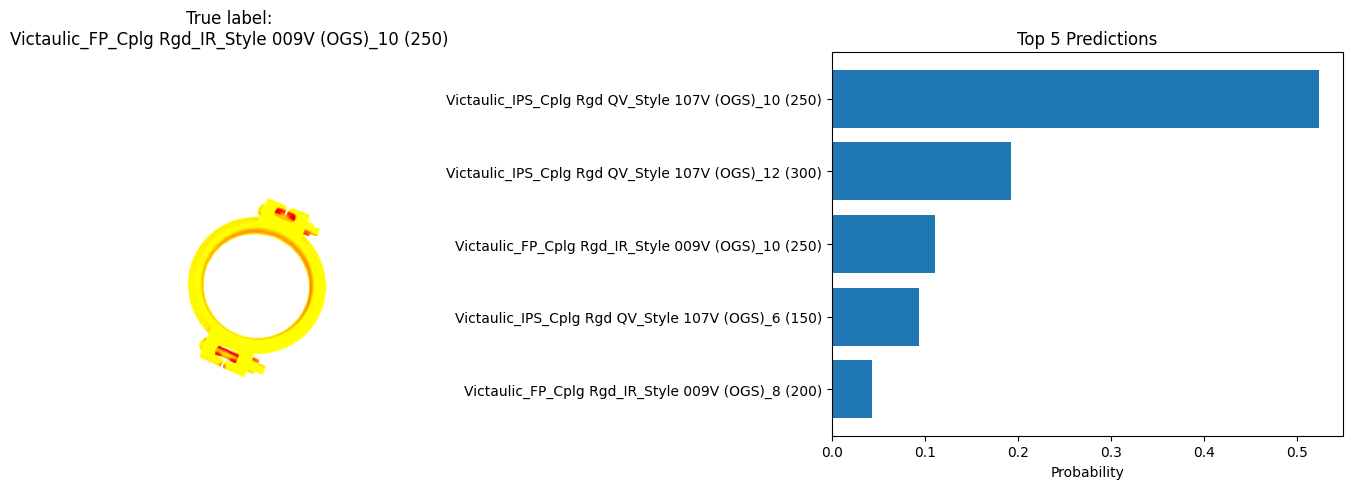

In [383]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def show_topk_prediction(model, dataset, k=5, index=2000, collapse_policy='first'):
    model.eval()
    
    # Get image + label
    img, label = dataset[index]
    img_batch = prepare_inputs_for_model(model, img, collapse_policy=collapse_policy).to(device)

    # Forward pass
    with torch.no_grad():
        logits = model(img_batch)
        probs = F.softmax(logits, dim=1)[0]
        topk_probs, topk_idx = torch.topk(probs, k=k)

    # Convert to numpy for plotting
    topk_probs = topk_probs.cpu().numpy()
    topk_idx = topk_idx.cpu().numpy()

    class_names = dataset.classes
    topk_labels = [class_names[i] for i in topk_idx]

    # For showing the image: if img is multi-view, pick the first view
    # If img was [V,C,H,W] or [C,H,W]
    if img.ndim == 4:
        img_show = img[0]
    elif img.ndim == 3:
        img_show = img
    else:
        img_show = img.squeeze()

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Show image
    ax[0].imshow(img_show.permute(1, 2, 0))  # CHW -> HWC
    ax[0].set_title(f"True label:\n{class_names[label]}")
    ax[0].axis("off")

    # Show bar chart
    ax[1].barh(topk_labels[::-1], topk_probs[::-1])
    ax[1].set_title(f"Top {k} Predictions")
    ax[1].set_xlabel("Probability")

    plt.tight_layout()
    plt.show()

# Example: show 1st test image
show_topk_prediction(model, test_data, k=5, index=100)

In [384]:
def calculate_topk_accuracy(model, data_loader, k=5, device="cuda"):
    model.eval()
    correct_1 = 0
    correct_k = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = prepare_inputs_for_model(model, images, collapse_policy='first').to(device), labels.to(device)
            outputs = model(images)
            
            # Get top k probabilities and indices
            _, topk_indices = outputs.topk(k, dim=1, largest=True, sorted=True)
            
            # Check if true label is in top 1 or top k
            total += labels.size(0)
            correct_1 += (topk_indices[:, 0] == labels).sum().item()
            
            for i in range(k):
                correct_k += (topk_indices[:, i] == labels).sum().item()
                
    acc_1 = 100 * correct_1 / total
    acc_k = 100 * correct_k / total
    print(f"Top-1 Accuracy: {acc_1:.2f}%")
    print(f"Top-{k} Accuracy: {acc_k:.2f}%")
    return acc_1, acc_k

# Execute on test loader
calculate_topk_accuracy(model, test_loader, k=5, device=device)

Top-1 Accuracy: 53.12%
Top-5 Accuracy: 92.71%


(53.125, 92.70833333333333)

Calibrating conformal predictor...
Calibration complete. Q_hat threshold: 0.9882
Calibration complete. Q_hat threshold: 0.9882


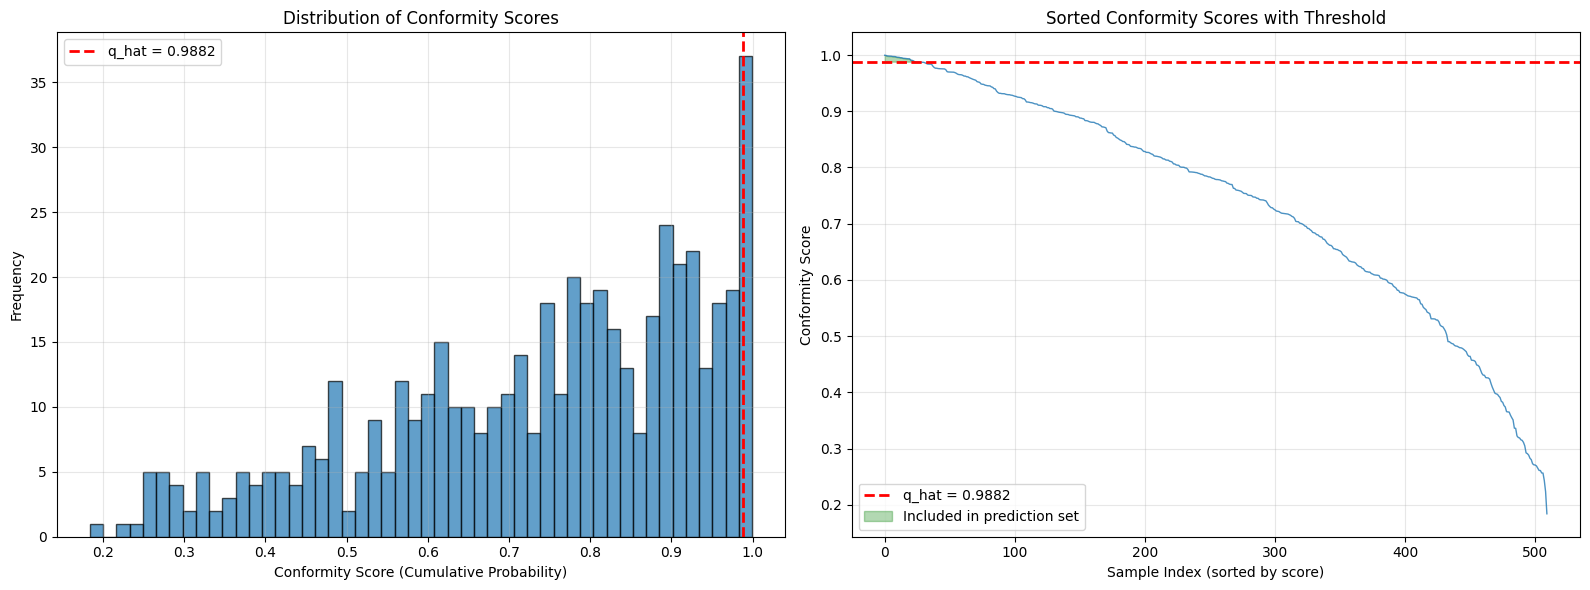


Prediction set for test sample 200: ['Victaulic_FP_Valve Btfl_Series 705 (OGS)_4 (100)', 'Victaulic_FP_Valve Btfl_Series 705 (OGS)_8 (200)', 'Victaulic_FP_Valve Btfl HP_Supervised Open_Series 765 (OGS)_4 (100)', 'Victaulic_FP_Valve Btfl_Series 705 (OGS)_6 (150)', 'Victaulic_FP_Valve Btfl_Series 705 (OGS)_2 (50)', 'Victaulic_FP_Valve Btfl HP_Supervised Open_Series 765 (OGS)_8 (200)', 'Victaulic_FP_Valve Btfl HP_Supervised Open_Series 765 (OGS)_6 (150)']
Number of classes in prediction set: 7
Empirical coverage on validation set: 4.71%


In [ ]:
import torch.nn.functional as F

def conformal_prediction_calibration(model, cal_loader, alpha=0.05, device="cuda", collapse_policy='first'):
    """
    Calibrates prediction sets using Adaptive Prediction Sets (APS) method.
    alpha: error rate (0.05 means 95% coverage guarantee)
    """
    model.eval()
    conformity_scores = []
    
    # 1. Calculate conformity scores on Calibration Set (Validation Data)
    print("Calibrating conformal predictor...")
    with torch.no_grad():
        for images, labels in cal_loader:
            images, labels = images.to(device), labels.to(device)

            # normalize inputs
            images = prepare_inputs_for_model(model, images, collapse_policy=collapse_policy)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            
            # Get probability of the true class
            # A simple score is 1 - prob_of_true_class
            # A better score (APS) sums probs from highest until true class is reached
            
            # Sort probabilities descending
            sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=1)
            
            # Find where the true label is in the sorted list
            # Create a mask of where the sorted index equals the true label
            # (This logic vectorizes finding the 'rank' of the true label)
            ranks = (sorted_indices == labels.unsqueeze(1)).float()
            
            # Cumulative sum of probabilities
            cum_probs = torch.cumsum(sorted_probs, dim=1)
            
            # The score is the cumulative probability up to the true label
            # We assume the label appears exactly once per row
            score = (cum_probs * ranks).sum(dim=1) 
            conformity_scores.append(score)
            
    all_scores = torch.cat(conformity_scores)
    
    # 2. Compute the quantile q_hat
    n = len(all_scores)
    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    q_hat = torch.quantile(all_scores, q_level, interpolation='higher')
    
    print(f"Calibration complete. Q_hat threshold: {q_hat:.4f}")
    return q_hat


def predict_sets(model, image, q_hat, class_names, device="cuda", collapse_policy='first'):
    """
    Predicts a set of classes for a single image with 1-alpha confidence.
    """
    model.eval()
    with torch.no_grad():
        # If `image` includes label (as returned by dataset[index]) unpack
        if isinstance(image, tuple) or isinstance(image, list):
            image = image[0]

        # Convert single sample into batch and normalize
        image_batch = prepare_inputs_for_model(model, image, collapse_policy=collapse_policy).to(device)

        output = model(image_batch)
        probs = F.softmax(output, dim=1).squeeze()
        
        # Sort probabilities
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cum_probs = torch.cumsum(sorted_probs, dim=0)
        
        # Select all classes where cumulative prob < q_hat (plus the first one that crosses)
        # We ensure at least 1 class is selected
        mask = cum_probs <= q_hat
        if mask.sum() < len(mask):
            mask[mask.sum()] = True # Include the boundary class
            
        selected_indices = sorted_indices[mask]
        prediction_set = [class_names[idx] for idx in selected_indices]
        
    return prediction_set

# Usage Order:
q_hat = conformal_prediction_calibration(model, val_loader)
prediction_set = predict_sets(model, test_data[200], q_hat, train_data.classes)

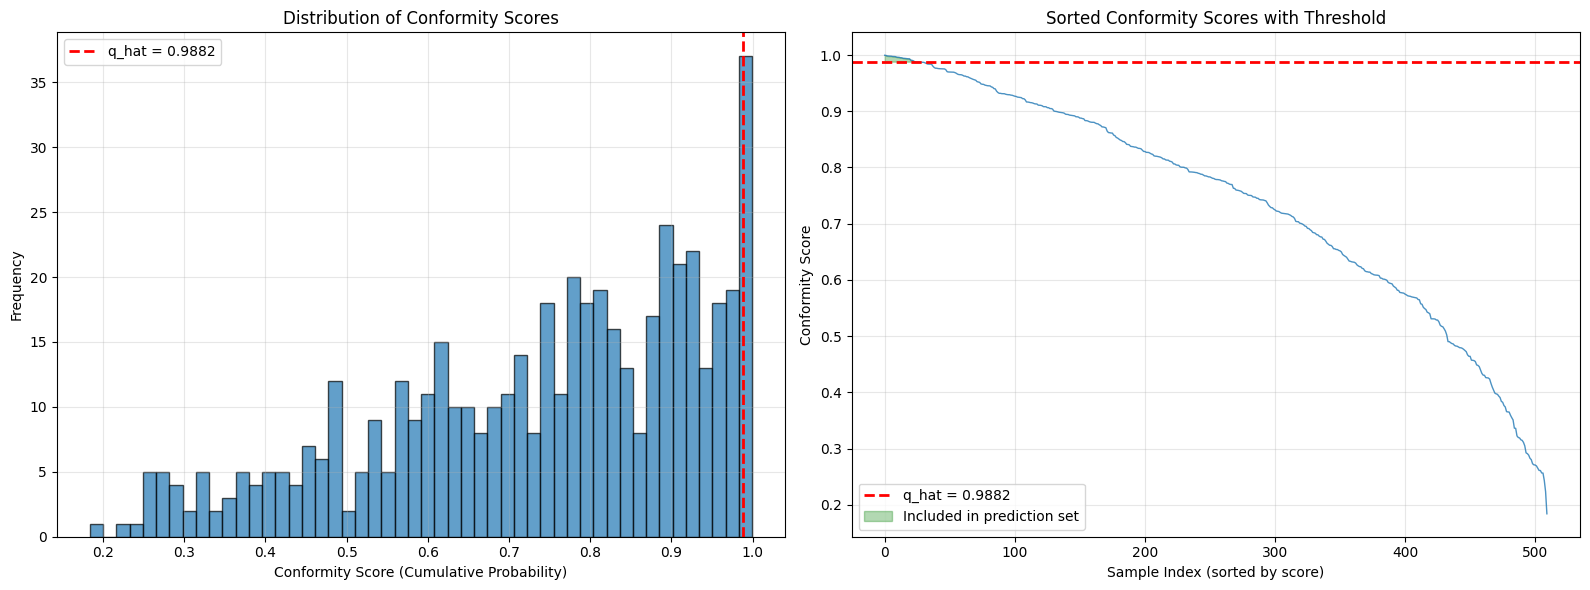


Prediction set for test sample 200: ['Victaulic_FP_Valve Btfl_Series 705 (OGS)_4 (100)', 'Victaulic_FP_Valve Btfl_Series 705 (OGS)_8 (200)', 'Victaulic_FP_Valve Btfl HP_Supervised Open_Series 765 (OGS)_4 (100)', 'Victaulic_FP_Valve Btfl_Series 705 (OGS)_6 (150)', 'Victaulic_FP_Valve Btfl_Series 705 (OGS)_2 (50)', 'Victaulic_FP_Valve Btfl HP_Supervised Open_Series 765 (OGS)_8 (200)', 'Victaulic_FP_Valve Btfl HP_Supervised Open_Series 765 (OGS)_6 (150)']
Number of classes in prediction set: 7
Empirical coverage on validation set: 4.71%


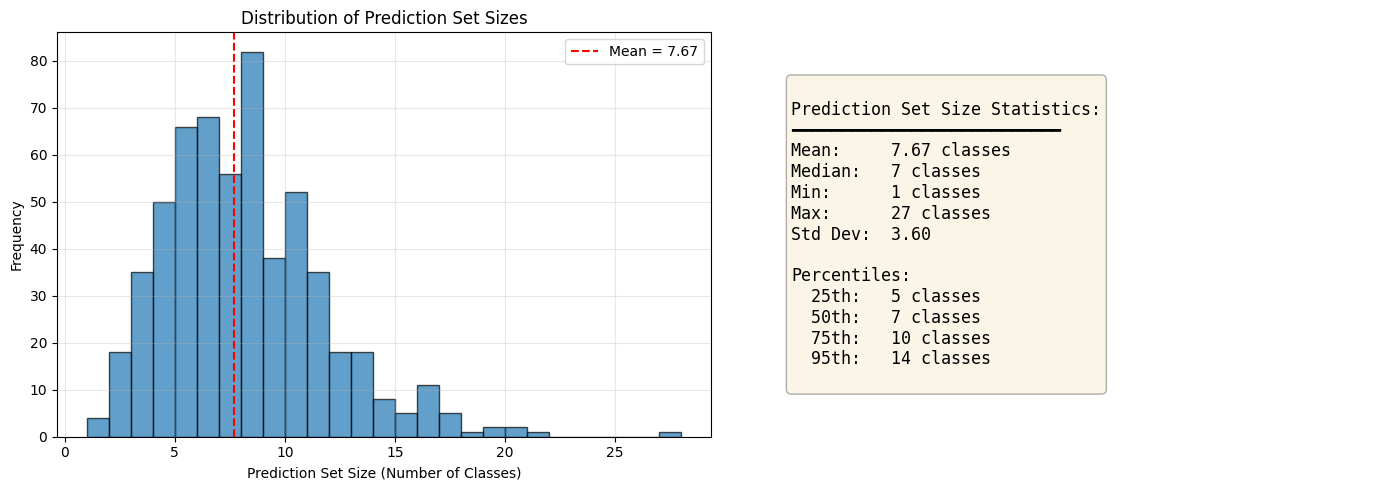


q_hat = 0.9882
Average prediction set size: 7.67 classes
Singleton predictions (size=1): 4 / 576 (0.7%)


In [391]:
# Visualize the conformal prediction threshold
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# LEFT: Histogram (current view)
conformity_scores_list = []
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images = prepare_inputs_for_model(model, images, collapse_policy='first').to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        
        sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=1)
        ranks = (sorted_indices == labels.unsqueeze(1)).float()
        cum_probs = torch.cumsum(sorted_probs, dim=1)
        score = (cum_probs * ranks).sum(dim=1)
        conformity_scores_list.append(score.cpu())

conformity_scores_cpu = torch.cat(conformity_scores_list).numpy()
sorted_scores = np.sort(conformity_scores_cpu)[::-1]  # descending

# Histogram view
ax[0].hist(sorted_scores, bins=50, alpha=0.7, edgecolor='black')
ax[0].axvline(q_hat.cpu().item(), color='red', linestyle='--', linewidth=2, label=f'q_hat = {q_hat:.4f}')
ax[0].set_xlabel('Conformity Score (Cumulative Probability)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Conformity Scores')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# RIGHT: Sorted view (conceptual interpretation)
ax[1].plot(sorted_scores, linewidth=1, alpha=0.8)
ax[1].axhline(q_hat.cpu().item(), color='red', linestyle='--', linewidth=2, label=f'q_hat = {q_hat:.4f}')
ax[1].fill_between(range(len(sorted_scores)), sorted_scores, q_hat.cpu().item(), 
                     where=(sorted_scores >= q_hat.cpu().item()), 
                     alpha=0.3, color='green', label='Included in prediction set')
ax[1].set_xlabel('Sample Index (sorted by score)')
ax[1].set_ylabel('Conformity Score')
ax[1].set_title('Sorted Conformity Scores with Threshold')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrediction set for test sample 200: {prediction_set}")
print(f"Number of classes in prediction set: {len(prediction_set)}")
coverage = (conformity_scores_cpu >= q_hat.cpu().item()).mean()
print(f"Empirical coverage on validation set: {coverage:.2%}")

# Analyze prediction set sizes across the test set
set_sizes = []
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = prepare_inputs_for_model(model, images, collapse_policy='first').to(device)
        
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        
        # For each sample, count how many classes needed
        for i in range(len(probs)):
            sample_probs = probs[i]
            sorted_probs, _ = torch.sort(sample_probs, descending=True)
            cum_probs = torch.cumsum(sorted_probs, dim=0)
            
            # Count classes where cumulative prob <= q_hat (plus boundary)
            mask = cum_probs <= q_hat
            if mask.sum() < len(mask):
                num_classes = mask.sum().item() + 1
            else:
                num_classes = len(mask)
            
            set_sizes.append(num_classes)

set_sizes = np.array(set_sizes)

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(set_sizes, bins=range(1, set_sizes.max()+2), alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Prediction Set Size (Number of Classes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prediction Set Sizes')
axes[0].axvline(set_sizes.mean(), color='red', linestyle='--', label=f'Mean = {set_sizes.mean():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Summary stats
axes[1].axis('off')
stats_text = f"""
Prediction Set Size Statistics:
━━━━━━━━━━━━━━━━━━━━━━━━━━━
Mean:     {set_sizes.mean():.2f} classes
Median:   {np.median(set_sizes):.0f} classes
Min:      {set_sizes.min():.0f} classes
Max:      {set_sizes.max():.0f} classes
Std Dev:  {set_sizes.std():.2f}

Percentiles:
  25th:   {np.percentile(set_sizes, 25):.0f} classes
  50th:   {np.percentile(set_sizes, 50):.0f} classes
  75th:   {np.percentile(set_sizes, 75):.0f} classes
  95th:   {np.percentile(set_sizes, 95):.0f} classes
"""
axes[1].text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center', 
             fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print(f"\nq_hat = {q_hat:.4f}")
print(f"Average prediction set size: {set_sizes.mean():.2f} classes")
print(f"Singleton predictions (size=1): {(set_sizes == 1).sum()} / {len(set_sizes)} ({100*(set_sizes == 1).mean():.1f}%)")

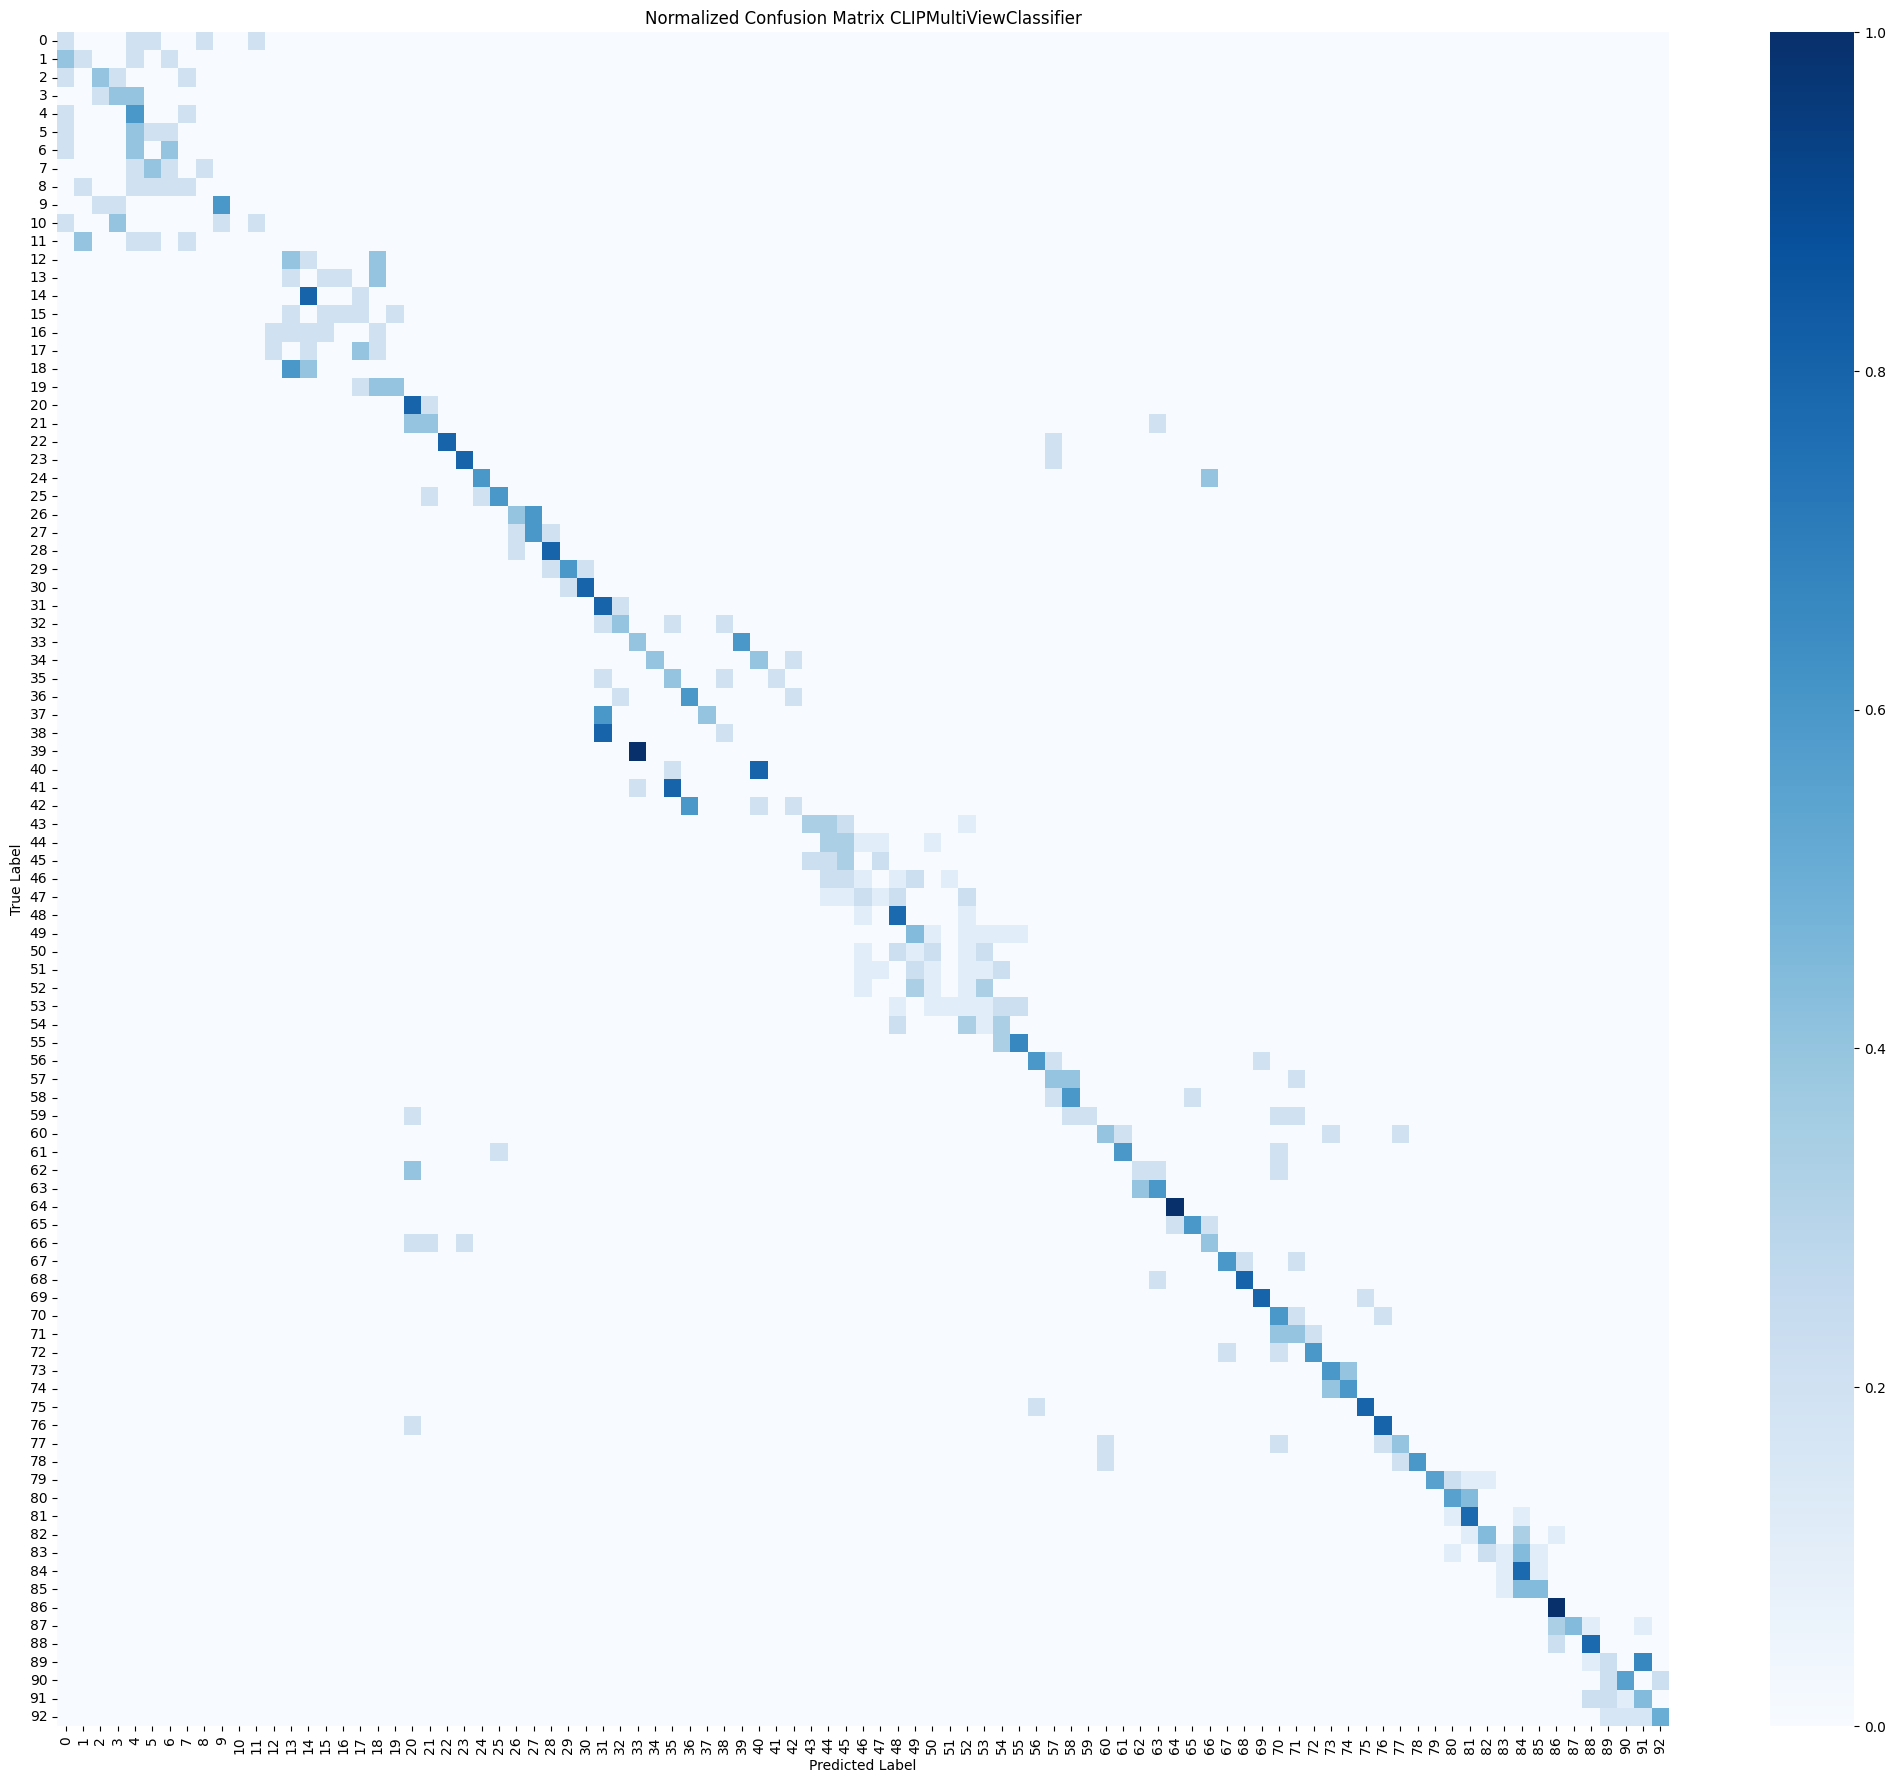

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(26, 22))
sns.heatmap(cm_norm, 
            cmap="Blues") 
            #xticklabels=class_names,
            #yticklabels=class_names)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title(f"Normalized Confusion Matrix {model.__class__.__name__}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Attention Rollout (??)

### t-SNE

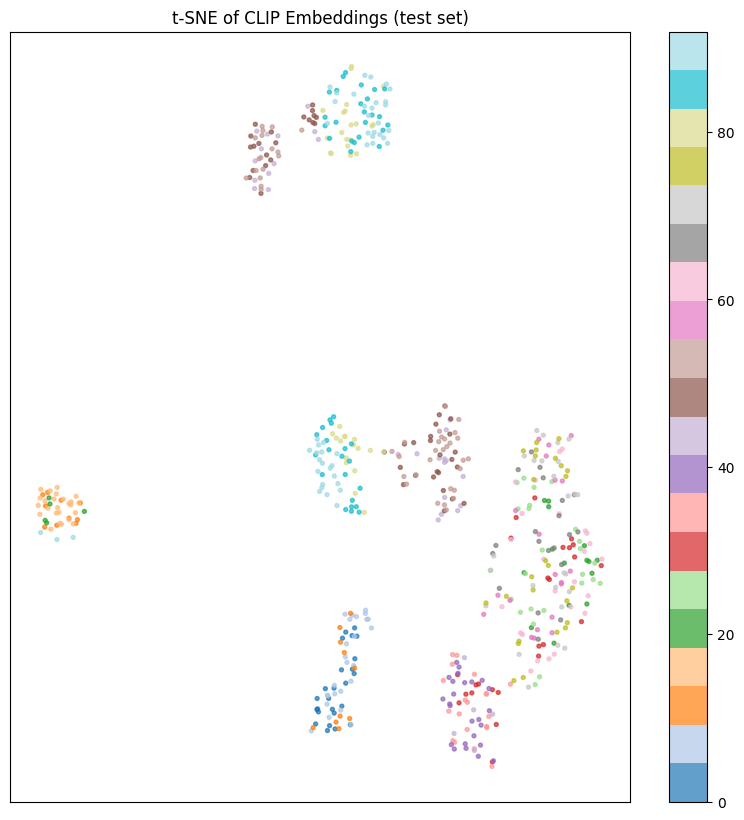

In [ ]:
from sklearn.manifold import TSNE

model.eval().to(device)
all_embeddings = []

with torch.no_grad():
    for images, labels in test_loader:
        images = prepare_inputs_for_model(model, images, collapse_policy='first').to(device)
        
        if model_name == 'CLIP':
            # Get CLIP embeddings
            B, V, C, H, W = images.shape
            flat_views = images.view(B * V, C, H, W)
            feats = model.clip.encode_image(flat_views)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            feats = feats.view(B, V, -1).mean(dim=1)
            
        elif model_name == 'dinov2':
            # Get DINOv2 CLS token embeddings
            features = model.backbone.forward_features(images)
            feats = features['x_norm_clstoken']
            
        elif model_name == 'ResNetWithMask':
            # Get ResNet embeddings before FC layer
            x = model.backbone.conv1(images)
            x = model.backbone.bn1(x)
            x = model.backbone.relu(x)
            x = model.backbone.maxpool(x)
            x = model.backbone.layer1(x)
            x = model.backbone.layer2(x)
            x = model.backbone.layer3(x)
            x = model.backbone.layer4(x)
            x = model.mask(x)  # Your spatial mask
            x = model.backbone.avgpool(x)
            feats = torch.flatten(x, 1)  # [B, 512]
        
        all_embeddings.append(feats.cpu().numpy())

all_embeddings = np.concatenate(all_embeddings, axis=0)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init="random", random_state=42)
emb_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=all_labels, s=8, alpha=0.7, cmap='tab20')
plt.colorbar(scatter)
plt.title(f"t-SNE of {model_name} Embeddings (test set)")
plt.xticks([]); plt.yticks([])
plt.show()

Scanning for 3 misclassified examples...

FAILURE CASE #1 (Index 1)
True Label: Victaulic_AWWA_Cap_No 60-C (DRG)_10 (250)
Predicted:  Victaulic_AWWA_Cap_No 60-C (DRG)_36 (900)


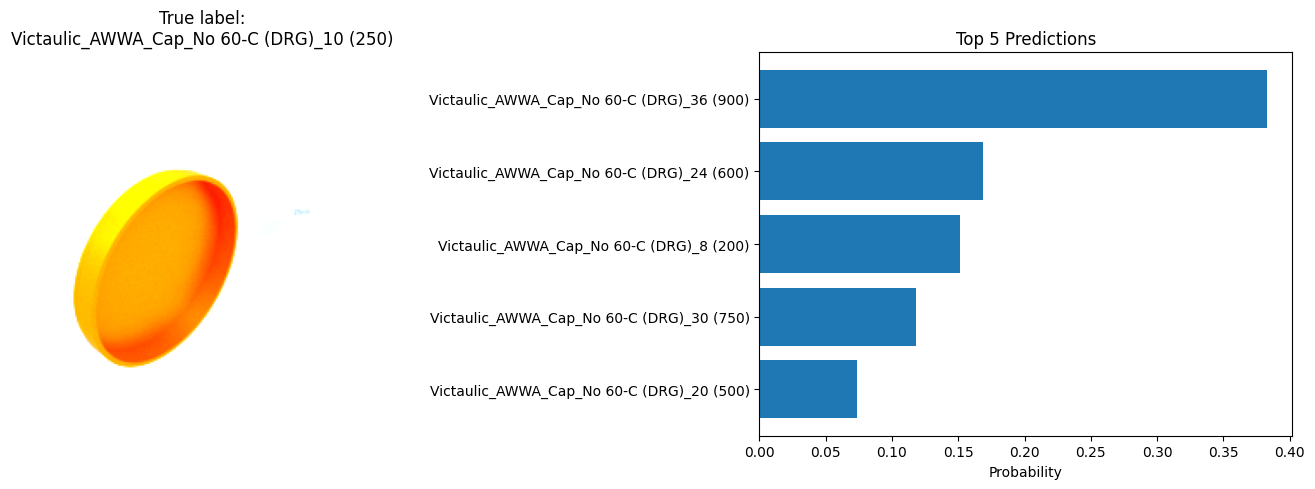


FAILURE CASE #2 (Index 2)
True Label: Victaulic_AWWA_Cap_No 60-C (DRG)_10 (250)
Predicted:  Victaulic_AWWA_Cap_No 60-C (DRG)_20 (500)


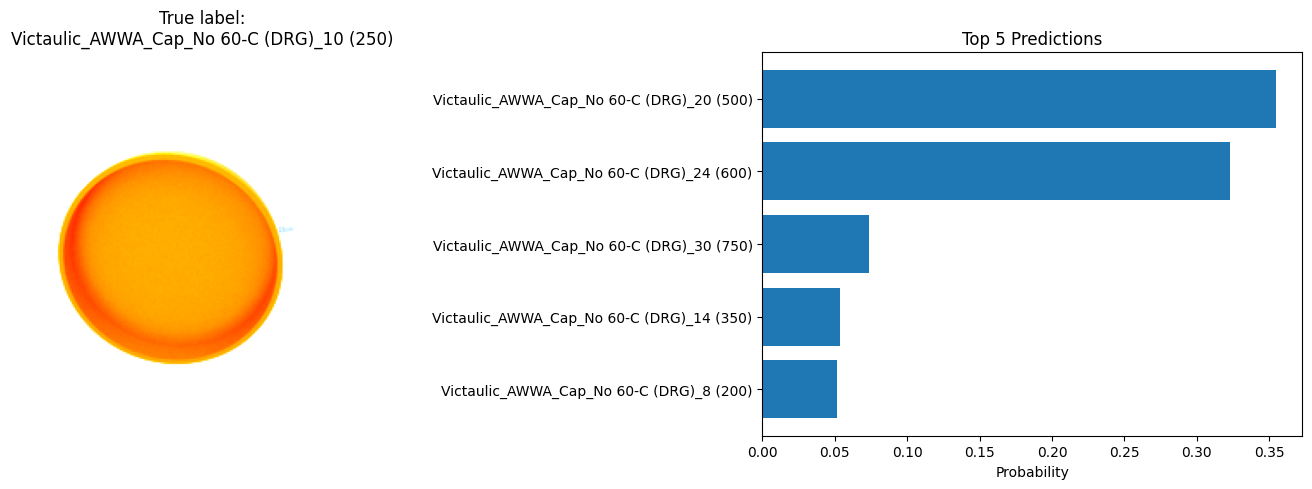


FAILURE CASE #3 (Index 3)
True Label: Victaulic_AWWA_Cap_No 60-C (DRG)_10 (250)
Predicted:  Victaulic_AWWA_Cap_No 60-C (DRG)_8 (200)


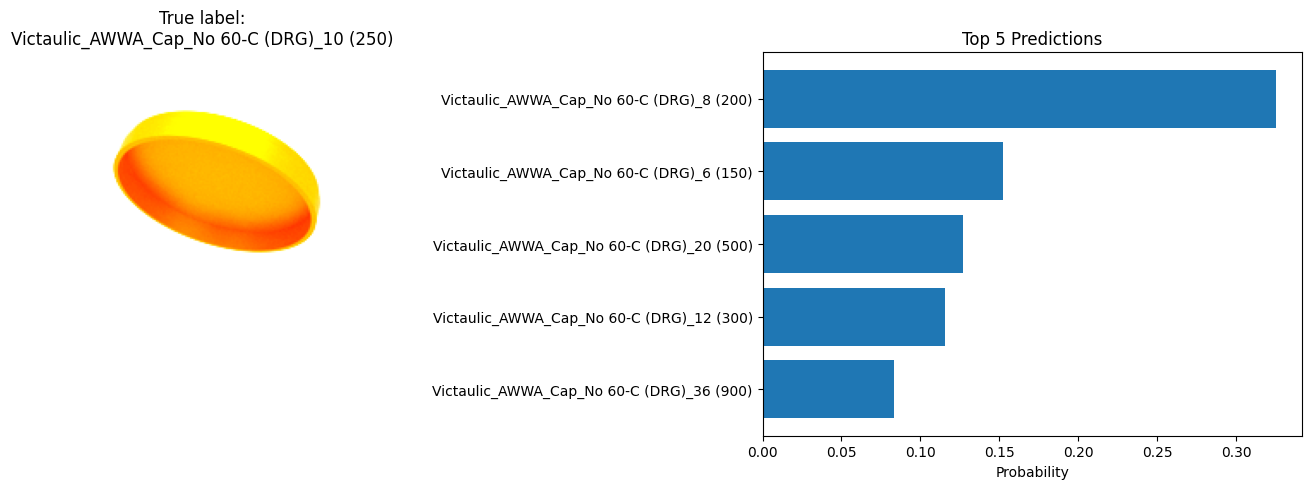

In [ ]:
import torch

def visualize_failures(model, dataset, num_failures=3, k=5, device="cuda", collapse_policy='first'):
    """
    Finds and visualizes incorrect predictions from the dataset.
    
    Args:
        model: Trained PyTorch model
        dataset: The dataset to scan (e.g., test_data)
        num_failures: Number of failure cases to display
        k: Number of top predictions to show in the bar chart
        collapse_policy: 'first' or 'mean' for multi-view aggregation
    """
    model.eval()
    count = 0
    print(f"Scanning for {num_failures} misclassified examples...")
    
    # Iterate through the dataset
    for i in range(len(dataset)):
        if count >= num_failures:
            break
            
        img, label = dataset[i]
        
        # Prepare input: Handle Multi-View [V, C, H, W] or Single-View [C, H, W]
        # We reuse your helper function to handle dimensions
        input_tensor = prepare_inputs_for_model(model, img, collapse_policy=collapse_policy).to(device)
        
        # Forward pass
        with torch.no_grad():
            logits = model(input_tensor)
            pred = logits.argmax(dim=1).item()
            
        # Check for failure
        if pred != label:
            count += 1
            print(f"\n{'='*20}")
            print(f"FAILURE CASE #{count} (Index {i})")
            print(f"True Label: {dataset.classes[label]}")
            print(f"Predicted:  {dataset.classes[pred]}")
            print(f"{'='*20}")
            
            # Call your existing visualization function
            show_topk_prediction(model, dataset, k=k, index=i, collapse_policy=collapse_policy)

# --- Usage ---
# visualizes 3 failures from the test set
visualize_failures(model, test_data, num_failures=3, k=5, device=device)

## GradCAM Visualization

In [ ]:
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def find_gradcam_target_layer(model):
    # Prefer conv2d last
    convs = [(name, m) for name, m in model.named_modules() if isinstance(m, torch.nn.Conv2d)]
    if convs:
        # pick last conv found
        return convs[-1][1], None

    # Fall back to transformer block. Try probable names:
    candidates = []
    for name, m in model.named_modules():
        if 'transformer' in name or 'blocks' in name or 'resblocks' in name or 'visual' in name:
            candidates.append((name, m))

    if candidates:
        # pick last candidate
        last_name, last_mod = candidates[-1]
        # We need reshape for transformer: find grid size from patch size or defaults
        # You may calculate H = W = int(224 / patch_size). Default: patch size 16 or 32.
        # You should set patch_size depending on model (or compute by inspecting patch_embed)
        reshape_err = "transformer"  # marker to indicate reshape_transform required
        return last_mod, reshape_err

    return None, None

def reshape_transform(tensor, height=7, width=7):
    # tensor: (B, N, C), where N = patch_count + 1 (class token)
    result = tensor[:, 1:, :]  # drop cls token
    result = result.reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)  # (B, C, H, W)
    return result

target_layer, reshape_hint = find_gradcam_target_layer(model)
if target_layer is None:
    raise RuntimeError("No valid GradCAM target layer found")
if reshape_hint == "transformer":
    # create and pass reshape_transform (patch grid size depends on model)
    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
else:
    cam = GradCAM(model=model, target_layers=[target_layer])

# Pick a ResNet layer — last conv layer
try:
    target_layer = model.backbone.layer4[-1].conv2   # works for ResNet18 with your mask
except Exception:
    # fallback for other architectures
    target_layer = None

# Initialize CAM (no use_cuda argument in new versions)
if target_layer is not None:
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Pick an image from test set
    img, label = test_data[298]
    input_tensor = prepare_inputs_for_model(model, img, collapse_policy='first').to(device)

    # CAM target (correct class)
    targets = [ClassifierOutputTarget(label)]

    # Generate CAM heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Convert image back to [0,1] range
    # If input was multiview, choose first view for visualization
    if img.ndim == 4:
        rgb_image = img[0]
    else:
        rgb_image = img

    rgb_image = rgb_image.permute(1,2,0).cpu().numpy()
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

    # Overlay heatmap
    vis = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(6,6))
    plt.imshow(vis)
    plt.axis("off")
    plt.title("Grad-CAM Heatmap")
    plt.show()
else:
    print("GradCAM not initialized: target_layer not found for this model type.")

GradCAM not initialized: target_layer not found for this model type.


## SHAP Analysis (WIP)

In [ ]:
# import numpy as np
# import random
# import shap
# import torch
# import torch.nn as nn
# import torchvision
# import torchvision.models.resnet
# from torchvision import transforms, datasets
# from captum.attr import GradientShap
# import matplotlib.pyplot as plt


# # ================================
# # FINAL SHAP PIPELINE FOR RESNET
# # ================================


# # ============================================
# # 1. SHAP Dataset (unnormalized images)
# # ============================================

# shap_transform = transforms.Compose([
#     transforms.Resize(size),
#     transforms.ToTensor(),               # IMPORTANT: NO NORMALIZATION HERE
# ])

# # Use your existing dataset paths:
# train_shap = datasets.ImageFolder(target_root / "train", transform=shap_transform)
# test_shap  = datasets.ImageFolder(target_root / "test",  transform=shap_transform)


# # ============================================
# # 2. Patch ResNet to remove all inplace ops
# # ============================================

# import torchvision.models.resnet as resnet

# def patch_resnet_for_shap(model):
#     for name, module in model.named_modules():

#         # Fix all ReLUs
#         if isinstance(module, nn.ReLU):
#             module.inplace = False

#         # Fix BasicBlock residual connections
#         if isinstance(module, resnet.BasicBlock):
#             def new_forward(self, x):
#                 identity = x.clone()

#                 out = self.conv1(x)
#                 out = self.bn1(out)
#                 out = self.relu(out)

#                 out = self.conv2(out)
#                 out = self.bn2(out)

#                 if self.downsample is not None:
#                     identity = self.downsample(identity)

#                 out = out + identity       # SAFE: not inplace
#                 out = self.relu(out)
#                 return out

#             module.forward = new_forward.__get__(module, module.__class__)


# patch_resnet_for_shap(model)   # use your trained model
# model.to(device)
# model.eval()


# # ============================================
# # 3. Wrap model to handle normalization internally
# # ============================================

# class NormalizedModel(nn.Module):
#     def __init__(self, model, mean, std):
#         super().__init__()
#         self.model = model
#         self.mean = torch.tensor(imagenet_mean).view(1, 3, 1, 1).to(device)
#         self.std  = torch.tensor(imagenet_std).view(1, 3, 1, 1).to(device)

#     def forward(self, x):
#         x = (x - self.mean) / self.std
#         return self.model(x)

# model_shap = NormalizedModel(model, mean, std).to(device)
# model_shap.eval()


# # ============================================
# # 4. Create SHAP background
# # ============================================

# background_size = 10
# background = torch.stack([train_shap[i][0] for i in range(background_size)]).to(device)


# # ============================================
# # 5. Build SHAP DeepExplainer
# # ============================================

# e = shap.DeepExplainer(model_shap, background)


# # ============================================
# # 6. Run SHAP on one test image
# # ============================================

# index = 0  # you can change this
# img, label = test_shap[index]
# image_tensor = img.unsqueeze(0).to(device)

# # Compute SHAP values
# shap_values = e.shap_values(image_tensor)

# # Convert image to numpy for plotting
# image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()

# # ============================================
# # 7. Plot SHAP heatmaps
# # ============================================

# shap.image_plot(shap_values, np.array([image_np]))


# # Model should take normalized images
# model.eval()

# # Prepare attribution method
# gs = GradientShap(model)

# # Pick an image
# img, label = shap_test_data[0]
# img_tensor = img.unsqueeze(0).to(device)

# # Baseline distribution (random noise)
# baseline = torch.zeros_like(img_tensor).to(device)
# baseline = baseline + 0.5*torch.randn_like(baseline)

# # Compute attributions
# attributions = gs.attribute(img_tensor, baselines=baseline, target=label)

# # Convert to numpy for visualization
# attr = attributions.squeeze().cpu().permute(1,2,0).numpy()

# # Visualize heatmap
# plt.figure(figsize=(6,6))
# plt.title("Gradient SHAP Attribution")
# plt.imshow(np.abs(attr).mean(axis=2), cmap='hot')
# plt.axis("off")
# plt.show()

# CycleGAN
This attempts to use a GAN to convert synthetic images into more realsitic photos without rendering. Not sure if it will work.

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_shape, num_residual_blocks=9):
        super(Generator, self).__init__()
        channels = input_shape[0]

        # Initial Convolution Block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual Blocks (The "Bottleneck" that preserves geometry)
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output Layer
        model += [nn.ReflectionPad2d(3), nn.Conv2d(64, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        channels, height, width = input_shape

        # Helper for conv blocks
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)
    
import itertools

# Initialize Models
G_AB = Generator((3, 256, 256)).cuda() # Synthetic -> Real
G_BA = Generator((3, 256, 256)).cuda() # Real -> Synthetic
D_A = Discriminator((3, 256, 256)).cuda() # Checks Real vs Fake Synthetic
D_B = Discriminator((3, 256, 256)).cuda() # Checks Real vs Fake Real

# Loss Functions
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# Hyperparameters
lambda_cyc = 10.0
lambda_id = 5.0

def training_step(real_A, real_B):
    # real_A: Batch of Synthetic Renders
    # real_B: Batch of Real Photos
    
    # ------------------
    #  Train Generators
    # ------------------
    optimizer_G.zero_grad()

    # Identity loss
    loss_id_A = criterion_identity(G_BA(real_A), real_A)
    loss_id_B = criterion_identity(G_AB(real_B), real_B)
    loss_identity = (loss_id_A + loss_id_B) / 2 * lambda_id

    # GAN loss
    fake_B = G_AB(real_A)
    loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B))) # Fool D_B
    
    fake_A = G_BA(real_B)
    loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A))) # Fool D_A
    
    loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

    # Cycle loss
    recov_A = G_BA(fake_B)
    loss_cycle_A = criterion_cycle(recov_A, real_A)
    
    recov_B = G_AB(fake_A)
    loss_cycle_B = criterion_cycle(recov_B, real_B)

    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2 * lambda_cyc

    # Total loss
    loss_G = loss_GAN + loss_cycle + loss_identity
    loss_G.backward()
    optimizer_G.step()

    # -----------------------
    #  Train Discriminator A
    # -----------------------
    optimizer_D_A.zero_grad()
    loss_real = criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A)))
    loss_fake = criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))
    loss_D_A = (loss_real + loss_fake) / 2
    loss_D_A.backward()
    optimizer_D_A.step()

    # -----------------------
    #  Train Discriminator B
    # -----------------------
    optimizer_D_B.zero_grad()
    loss_real = criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B)))
    loss_fake = criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))
    loss_D_B = (loss_real + loss_fake) / 2
    loss_D_B.backward()
    optimizer_D_B.step()

In [ ]:
dataloader_synthetic = ...
dataloader_real = ...

# training loop
num_epochs = 100

for epoch in range(num_epochs):
    for (real_A, _), (real_B, _) in zip(dataloader_synthetic, dataloader_real):
        real_A = real_A.cuda()
        real_B = real_B.cuda()
        
        training_step(real_A, real_B)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] completed")

# process synthetic images through G_AB to get realistic images
G_AB.eval()
with torch.no_grad():
    for i, (synthetic_imgs, _) in enumerate(dataloader_synthetic):
        synthetic_imgs = synthetic_imgs.cuda()
        fake_realistic_imgs = G_AB(synthetic_imgs)
        # Save or use fake_realistic_imgs as needed